<!--
# Copyright (c) 2025 PaddlePaddle Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
-->

# Autoregressive Image Generation without Vector Quantization

This notebook samples from pre-trained MAR+DiffLoss models, which are class-conditional masked autoregressive models trained on ImageNet to model continuous latent tokens. MAR+DiffLoss achieves state-of-the-art performance on the ImageNet benchmarks. A large portion of this demo is adopted from [DiT](https://github.com/facebookresearch/DiT).

[Paper](https://arxiv.org/abs/2406.11838) | [GitHub](https://github.com/LTH14/mar)

# 1. Setup

We recommend using GPUs (Runtime > Change runtime type > Hardware accelerator > GPU). Run this cell to start.

In [1]:
import os
# 需根据实际项目地址更改parent_path
parent_path = r'/home/aistudio/PaddleMix/paddlemix/'
print(parent_path)
sys.path.append(parent_path)

import numpy as np
from models.mar import mar
from models.mar.vae import AutoencoderKL
from models.mar.APIs.self_use_save_image import save_image
from IPython.display import display
import random
from PIL import Image
import paddle
paddle.set_device('gpu:0') 
print("OK")

/home/aistudio/PaddleMix/paddlemix/
OK


# 2. Load pre-trained MAR models

In [2]:

model_type = "mar_huge" #@param ["mar_base", "mar_large", "mar_huge"]
num_sampling_steps_diffloss = 100 #@param {type:"slider", min:1, max:1000, step:1}
if model_type == "mar_base":
  model_path = "exchange/mar/paddle_mar_base.pdparams"
  diffloss_d = 6
  diffloss_w = 1024
elif model_type == "mar_large":
  model_path = "exchange/mar/paddle_mar_large.pdparams"
  diffloss_d = 8
  diffloss_w = 1280
elif model_type == "mar_huge":
  model_path = "exchange/mar/paddle_mar_huge.pdparams"
  diffloss_d = 12
  diffloss_w = 1536
else:
  raise NotImplementedError

model = mar.__dict__[model_type](
  buffer_size=64,
  diffloss_d=diffloss_d,
  diffloss_w=diffloss_w,
  num_sampling_steps=str(num_sampling_steps_diffloss)
)

state_dict = paddle.load(model_path)
model.set_state_dict(state_dict)
model.eval() # important!

vae = AutoencoderKL(embed_dim=16, ch_mult=(1, 1, 2, 2, 4), ckpt_path="exchange/mar/VAE_kl16_ckpt.pdparams")
vae.eval()

W0519 09:46:09.855297 16706 gpu_resources.cc:119] Please NOTE: device: 0, GPU Compute Capability: 7.0, Driver API Version: 12.0, Runtime API Version: 11.8
W0519 09:46:09.856305 16706 gpu_resources.cc:164] device: 0, cuDNN Version: 8.9.
Working with z of shape (1, 16, 16, 16) = 4096 dimensions.
Loading pre-trained KL-VAE
Missing keys:
[]
Unexpected keys:
[]
Restored from exchange/mar/VAE_kl16_ckpt.pdparams


# 3. Sample from Pre-trained MAR Models

You can customize several sampling options. For the full list of ImageNet classes, [check out this](https://deeplearning.cms.waikato.ac.nz/user-guide/class-maps/IMAGENET/).

In [3]:
# Set user inputs:
seed = 0 #@param {type:"number"}
random.seed(seed)
paddle.seed(seed)  
np.random.seed(seed)
num_ar_steps = 64 #@param {type:"slider", min:1, max:256, step:1}
cfg_scale = 4 #@param {type:"slider", min:1, max:10, step:0.1}
cfg_schedule = "constant" #@param ["linear", "constant"]
temperature = 1.0 #@param {type:"slider", min:0.9, max:1.1, step:0.01}
class_labels = [207, 360, 388, 113, 355, 980, 323, 979] #@param {type:"raw"}
samples_per_row = 4 #@param {type:"number"}
labels = paddle.to_tensor(class_labels, dtype='int64').cuda()
    

with paddle.no_grad():# important!
    with paddle.amp.auto_cast(enable=True, custom_white_list=None, custom_black_list=None, level='O1'):
        sampled_tokens = model.sample_tokens(
            bsz=len(class_labels), 
            num_iter=num_ar_steps,
            cfg=cfg_scale, 
            cfg_schedule=cfg_schedule,
            labels=labels,
            temperature=temperature, 
            progress=True)
        print("mean",paddle.mean(sampled_tokens))
        print("min",paddle.min(sampled_tokens))
        print("max",paddle.max(sampled_tokens))
        sampled_images = vae.decode(sampled_tokens / 0.2325)
    

100%|██████████| 64/64 [01:24<00:00,  1.33s/it]
mean Tensor(shape=[], dtype=float32, place=Place(gpu:0), stop_gradient=True,
       -0.08168913)
min Tensor(shape=[], dtype=float16, place=Place(gpu:0), stop_gradient=True,
       -5.54296875)
max Tensor(shape=[], dtype=float16, place=Place(gpu:0), stop_gradient=True,
       4.33593750)


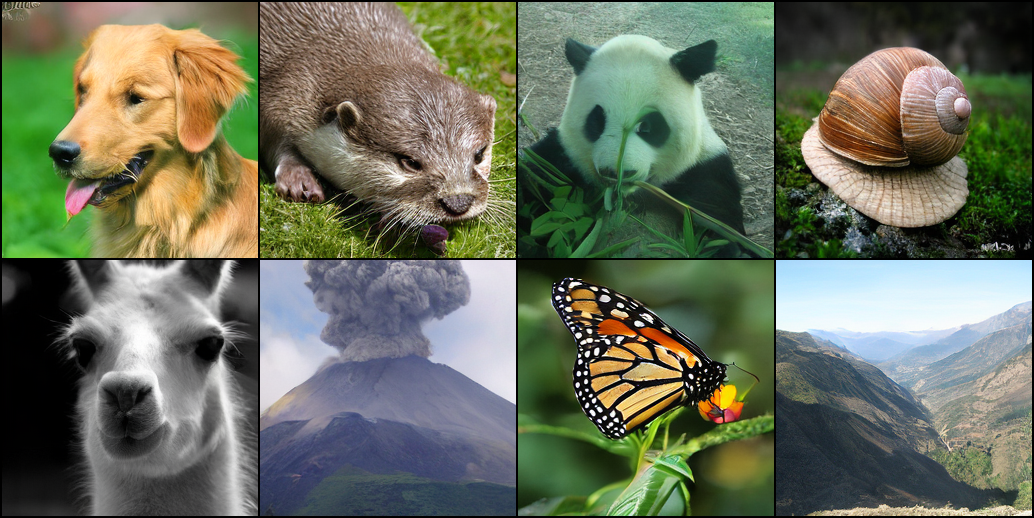

In [4]:
# Save and display images:
save_image(sampled_images, "sample.png", nrow=int(samples_per_row), normalize=True, value_range=(-1, 1))
samples = Image.open("sample.png")
display(samples)